# Importación de Librerías

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import hdbscan

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import make_pipeline, Pipeline
from pandas.plotting import parallel_coordinates

from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster.elbow import kelbow_visualizer
import plotly.express as px

import os



# Lectura de Archivo

In [4]:
MAIN_FOLDER = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path= os.path.join(MAIN_FOLDER, "data", "model", "ohe_customer_dataset.csv")

In [5]:
data = pd.read_csv(data_path, sep=",")
data

,transactionAmount,transactionFailed,fraudulent,orderAmount_10.0,orderAmount_11.0,orderAmount_12.0,orderAmount_13.0,orderAmount_14.0,orderAmount_15.0,orderAmount_16.0,...,emailDomain_net,emailDomain_org,emailDomain_weird,emailProvider_gmail,emailProvider_hotmail,emailProvider_other,emailProvider_weird,emailProvider_yahoo,customerIPAddressSimplified_digits_and_letters,customerIPAddressSimplified_only_letters
0,18,False,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
1,26,False,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
2,45,False,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
3,23,False,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
4,43,True,1,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,25,True,2,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
619,25,True,2,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
620,25,False,2,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
621,19,False,2,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True


In [5]:
# copia de las columnas a interesar
filter_data = data[["orderState_failed", "orderState_fulfilled", "orderState_pending", "transactionFailed", "fraudulent", "customerIPAddressSimplified_digits_and_letters"]].copy()

# Clustering con K-Means 🎯

In [6]:
# Pasos a utilizar en el pipeline
steps = [
    ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
    ('kmeans', KMeans(n_clusters=3, random_state=0, init='k-means++', max_iter=100, n_init='auto'))
]


In [7]:
# instanciar el pipeline
pipeline=Pipeline(steps)

In [8]:
# ajustar el pipelial conjunto de datos
pipeline.fit(filter_data)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(max_iter=100, n_clusters=3, random_state=0))])

In [9]:
# calculo de la incercia 
pipeline.named_steps['kmeans'].inertia_

2217.4984846907764

In [10]:
#prediccion
pred_km= pipeline.predict(filter_data)


# elbow method

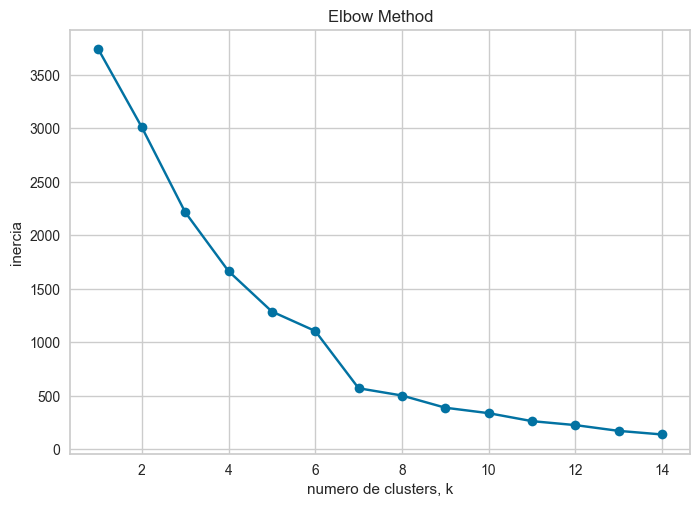

In [11]:
ks=range(1, 15)
inertia = []    

for k in ks:
    pipeline = Pipeline([
        ('scaler', StandardScaler(copy= True, with_mean=True, with_std=True)),

        ('kmeans', KMeans(n_clusters=k, random_state=0, init='k-means++', max_iter=100, n_init='auto')) # iteracion entre los k en ks
    ])
    pipeline.fit(filter_data)
    inertia.append(pipeline.named_steps['kmeans'].inertia_)

plt.plot(ks, inertia, marker='o')
plt.xlabel('numero de clusters, k')
plt.ylabel('inercia')
plt.title('Elbow Method')
plt.show()

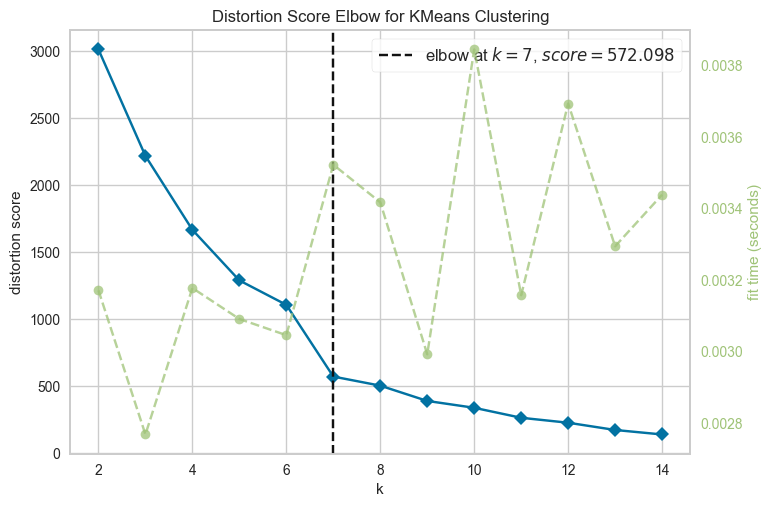

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(max_iter=100, n_clusters=14, random_state=0),
                 k=(2, 15))

In [12]:
#esto no permite el uso de pipeline
# Escalado manual sin pasos por el pipeline para que pueda iterar
scaler_m= StandardScaler(copy=True, with_mean=True, with_std=True)
X_scaled = scaler_m.fit(filter_data)
X_scaled = scaler_m.transform(filter_data)
kelbow_visualizer(KMeans(init='k-means++', max_iter=100, random_state=0, n_init='auto'),
                  X_scaled, k=(2, 15), locate_elbow=True)

### Conclusión 
- Según los graficos y los cruces de las lineas se puede escoger entre 5 y 6 clusters

# Graficar los Clusters

In [13]:
# hacemos una copia del df
filter_data_c=  filter_data.copy()

In [14]:
# Visualización de los clusters
# 1. Escalar los datos (sin la columna cluster)
scaler_minmax = MinMaxScaler()
X_minmax = pd.DataFrame(scaler_minmax.fit_transform(filter_data_c), columns=filter_data_c.columns)

# 2. Reajustar el modelo KMeans si es necesario
kmeans = KMeans(n_clusters=3, random_state=0, init='k-means++', max_iter=100, n_init='auto')
kmeans.fit(X_minmax)

# 3. Crear DataFrame con los centroides
centroides_minmax = pd.DataFrame(kmeans.cluster_centers_, columns=filter_data_c.columns) # no se utiliza el centroide del pipeline porque tiene otro scaler y se utiliza de una ves cluster center en vez de la agrupacion 
centroides_minmax['cluster'] = centroides_minmax.index.astype(str)



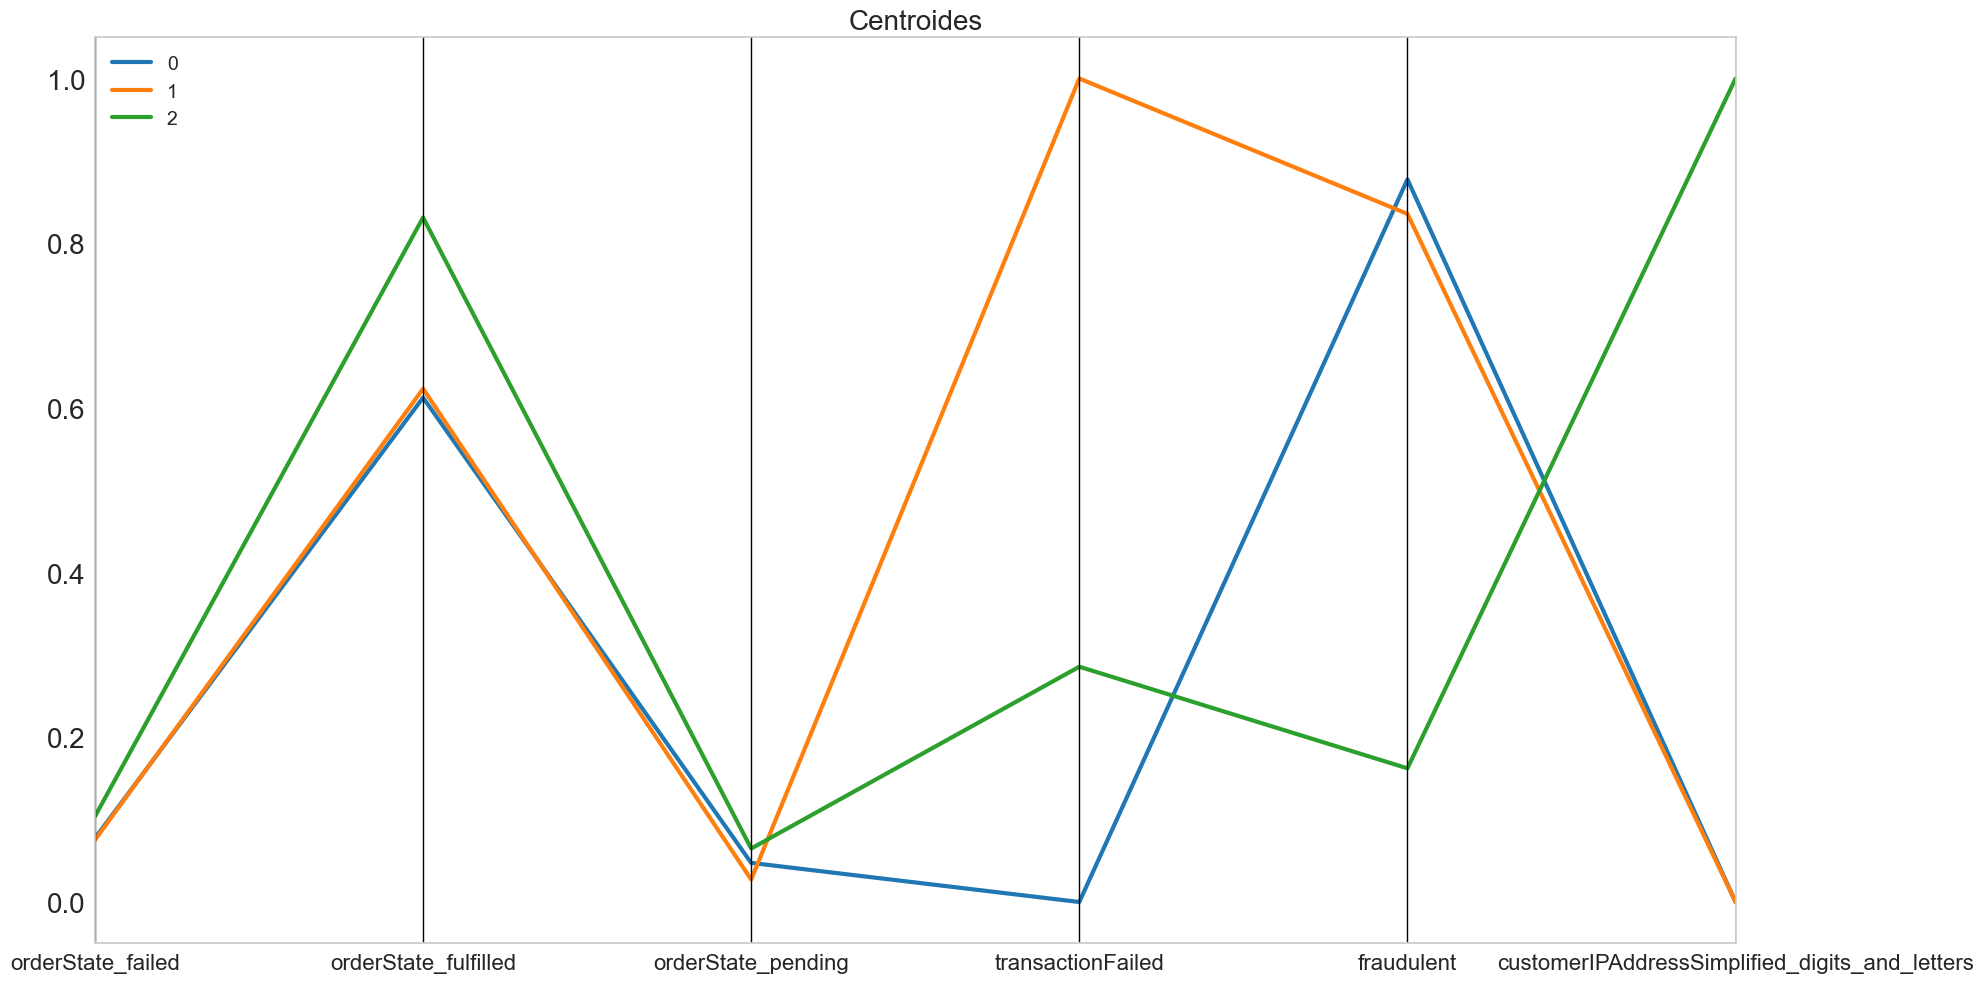

In [15]:
# 4. Graficar
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']
plt.figure(figsize=(20, 10))
parallel_coordinates(centroides_minmax, class_column='cluster', linewidth=3,color=colores)
plt.title("Centroides",fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Insights

### Insights 1
🔍 Cluster 0 – 🔵 Azul: Clientes posiblemente legítimos pero con riesgo medio
- fraudulent: muy alto

- transactionFailed: muy bajo

- orderState_fulfilled: medio

🔎 Interpretación: Usuarios que completan pedidos normalmente pero que tienen fuerte relación con fraude. Podrían ser fraudes sofisticados o internos.

### Insights 2
🔍 Cluster 1 – 🟠 Naranja: Clientes de alto riesgo
- transactionFailed: valor máximo

- fraudulent: alto

- customerIPAddressSimplified_digits_and_letters: muy bajo

🔎 Interpretación: Este grupo representa a clientes con más fallas en transacciones y fuerte asociación a fraude.
Posiblemente bots o ataques sistemáticos desde IPs sospechosas. Grupo crítico para monitorear.



### Insights 3
🔍 Cluster 2 – 🟢 Verde: Clientes normales / confiables

- fraudulent: valor más bajo

- transactionFailed: medio

- customerIPAddressSimplified_digits_and_letters: alto

- orderState_fulfilled: más alto del conjunto

🔎 Interpretación: Este cluster parece agrupar a clientes con comportamiento normal: pedidos cumplidos, menos fraude, direcciones IP estructuradas. Bajo riesgo.

# Conclusión 
El Cluster 1 (🟠) representa al grupo más riesgoso: combina máximo nivel de transacciones fallidas con alta proporción de fraude y características sospechosas en IP.

El Cluster 2 (🟢) puede considerarse como clientes confiables

 Cluster 0 (🔵) requiere evaluación más fina por su asociación a fraude sin fallos evidentes en transacciones.

# Gráfico 3d

In [16]:
fig = px.scatter_3d(filter_data, x='orderState_failed', y='customerIPAddressSimplified_digits_and_letters',
                     z='transactionFailed', color='fraudulent')
fig.show()

# Clustering con HDBSCAN 🤖

In [17]:
# copiamos la data
filter_data_h= filter_data.copy()

In [18]:
#hacemos un nuevo df escalado con mixmax
X_minmax_h = pd.DataFrame(scaler_minmax.fit_transform(filter_data_h), columns=filter_data_h.columns)

In [19]:
#instanciamos el modelo
model_hdb = hdbscan.HDBSCAN(min_cluster_size=15)


In [20]:
# ajustamos y predecimos
labels= model_hdb.fit_predict(X_minmax_h)

c:\Users\tomasito\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\tomasito\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [21]:
# creamos la columna cluster e instaciamos a las etiquetas del modelo
X_minmax_h['cluster'] = labels.astype(str)

In [22]:
#queitamos el ruido y calculamos los centroides 
centroides_minmax_h = X_minmax_h[X_minmax_h['cluster'] != '-1'].groupby('cluster').mean().reset_index()


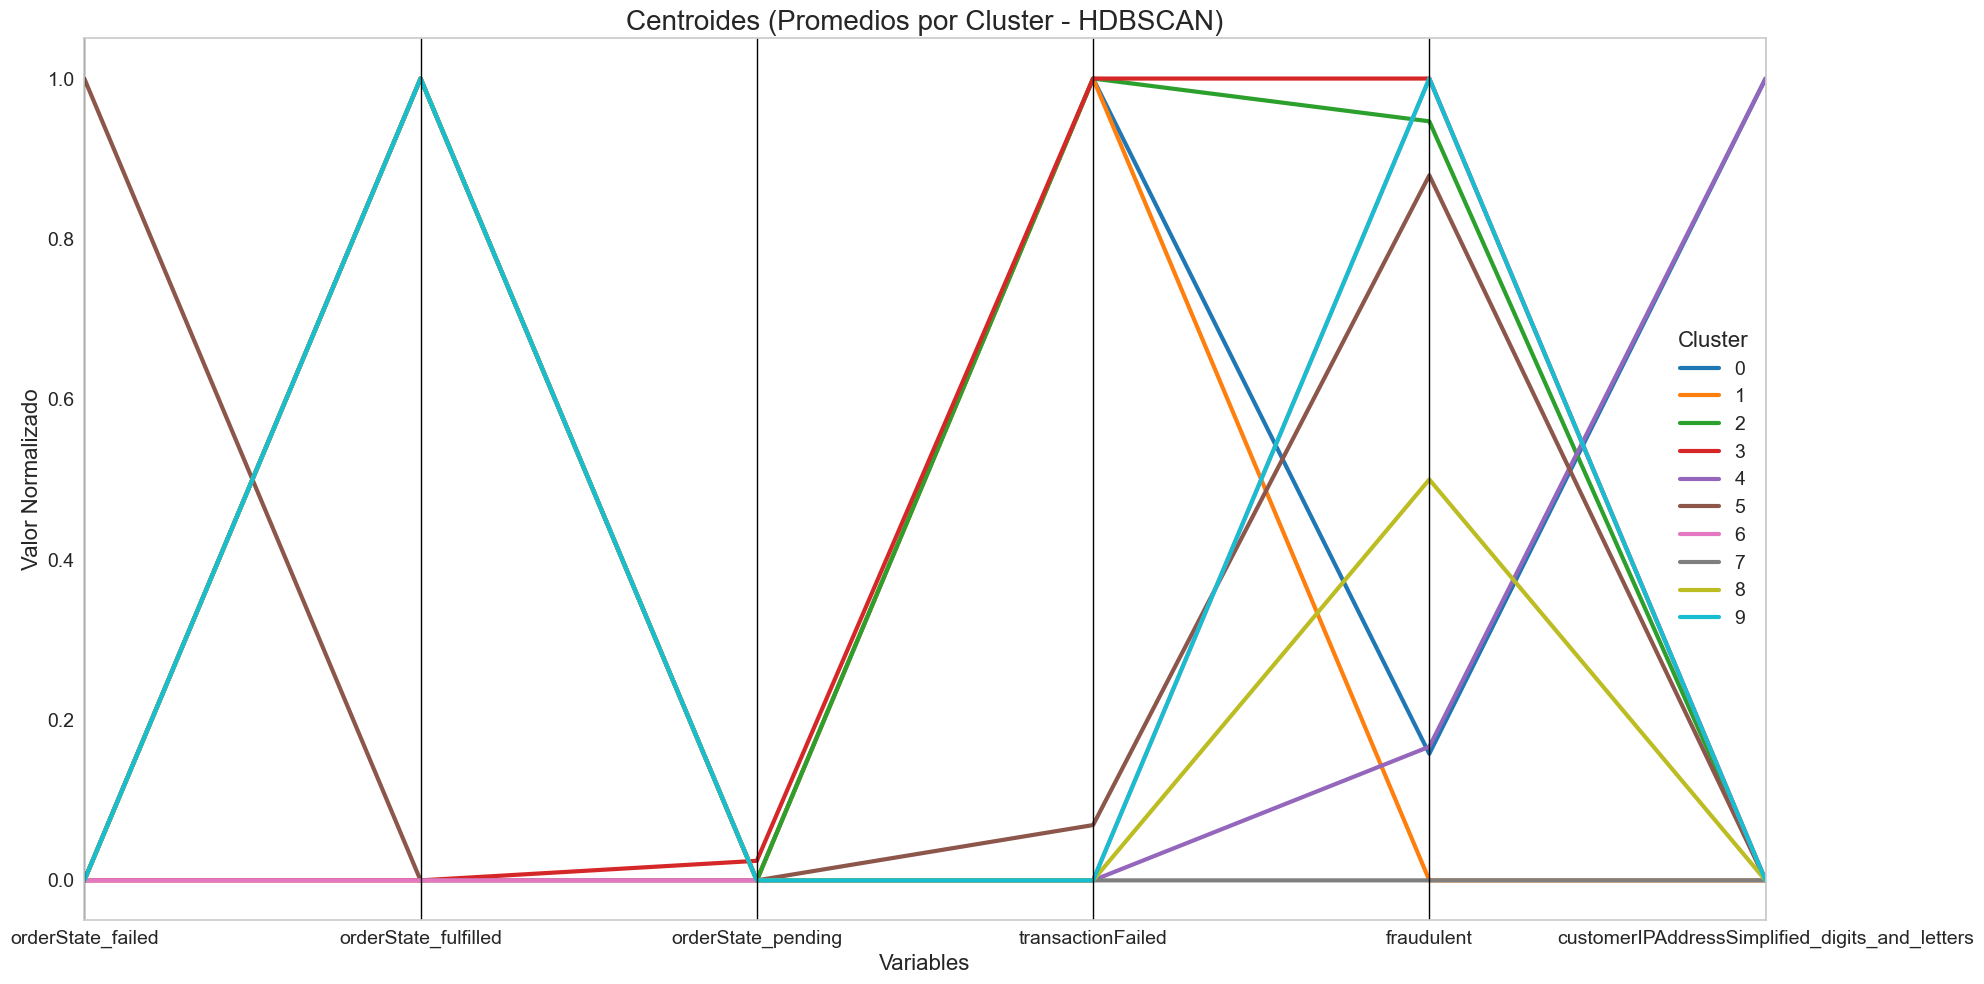

In [23]:
colores = [
    '#1f77b4',  # azul
    '#ff7f0e',  # naranja
    '#2ca02c',  # verde
    '#d62728',  # rojo
    '#9467bd',  # púrpura
    '#8c564b',  # marrón
    '#e377c2',  # rosa
    '#7f7f7f',  # gris
    '#bcbd22',  # oliva
    '#17becf',  # celeste
    '#aec7e8',  # azul claro
    '#ffbb78',  # naranja claro
]

plt.figure(figsize=(20, 10))
parallel_coordinates(centroides_minmax_h, class_column='cluster', linewidth=3, color=colores)
plt.title("Centroides (Promedios por Cluster - HDBSCAN)", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Variables", fontsize=16)
plt.ylabel("Valor Normalizado", fontsize=16)
plt.legend(title="Cluster", fontsize=14, title_fontsize=16)
plt.tight_layout()
plt.show()

# Sanity Check

In [24]:
#copiamos el dataset original
data_check= filter_data.copy()

In [25]:
# creamos la columna cluster e instaciamos a las etiquetas
data_check['cluster']=model_hdb.labels_

In [26]:
#chequeamos que se creo el df correctamente
data_check.head(3)

,orderState_failed,orderState_fulfilled,orderState_pending,transactionFailed,fraudulent,customerIPAddressSimplified_digits_and_letters,cluster
0,False,False,True,False,0,False,-1
1,False,True,False,False,1,False,8
2,False,True,False,False,0,True,4


# 🔍 Insight 1: 
- Cluster 3 y 2 muestran alto riesgo por fraude y fallo. Ambos tienen valores cercanos a 1.0 en transactionFailed y en fraudulent.

- Estos clusters representan clientes con mayores probabilidades de fraude y fallos recurrentes en transacciones.

- 💡 Podrían ser bots, scripts automatizados o usuarios maliciosos con patrones evidentes.


# 🔍 Insight 2: 
- Cluster 5 presenta muchas fallas pero bajo riesgo de fraude.Este grupo se destaca por tener la mayor proporción de pedidos fallidos (orderState_failed) y la menor tasa de pedidos completados (orderState_fulfilled).

- El valor de fraudulent es bajo, lo que indica que no se asocian con actividades maliciosas.

- Los usuarios en este cluster parecen experimentar problemas operativos o técnicos frecuentes, pero no muestran patrones de fraude.Podrían representar clientes legítimos que enfrentan obstáculos para completar sus transacciones, como errores del sistema, métodos de pago fallidos o problemas logísticos.

# 🔍 Insight 3: 
- Cluster 4 se caracteriza por direcciones IP inusuales (IPv6)

- Este grupo presenta el valor más alto en la variable customerIPAddressSimplified_digits_and_letters, lo que sugiere un uso intensivo de caracteres especiales o mezclas atípicas en las direcciones IP lo que se concluye como el uso de IPv6.

- Presenta un riesgo al fraude bajo en relacion con otras caracteristicas.

- Este patrón puede indicar la presencia de usuarios que acceden desde entornos no convencionales, como VPNs, proxies o IPs generadas automáticamente con IPv6



# Silhoutte

In [ ]:
#calculo del score
sil_avg = silhouette_score(filter_data, model_hdb.labels_)
sil_avg

0.8102918891856868

In [ ]:
# valor de silohuette por cada registro
sample_silhouette_values = silhouette_samples(filter_data, model_hdb.labels_)


In [ ]:
# creacion del df
res_sil=pd.DataFrame({'sil_value': sample_silhouette_values, 'cluster': model_hdb.labels_})

c:\Users\tomasito\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\tomasito\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\tomasito\AppData\Local\Temp\ipykernel_27552\150851689.py:1: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



<Axes: xlabel='sil_value', ylabel='Density'>

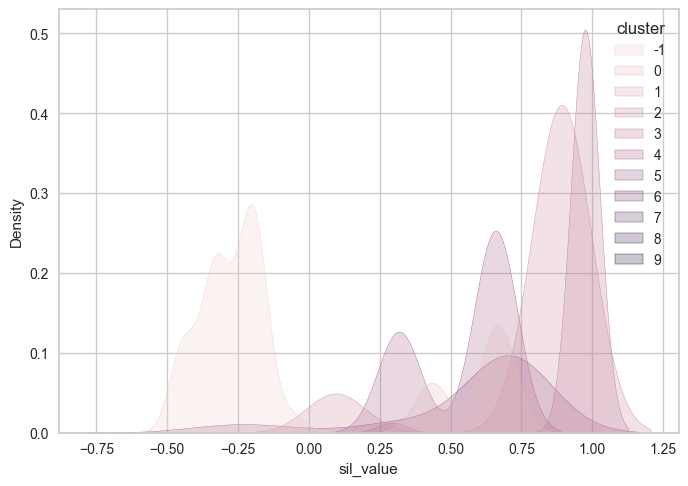

In [39]:
sns.kdeplot(data=res_sil, x='sil_value', hue='cluster', fill=True)


<Axes: xlabel='cluster', ylabel='sil_value'>

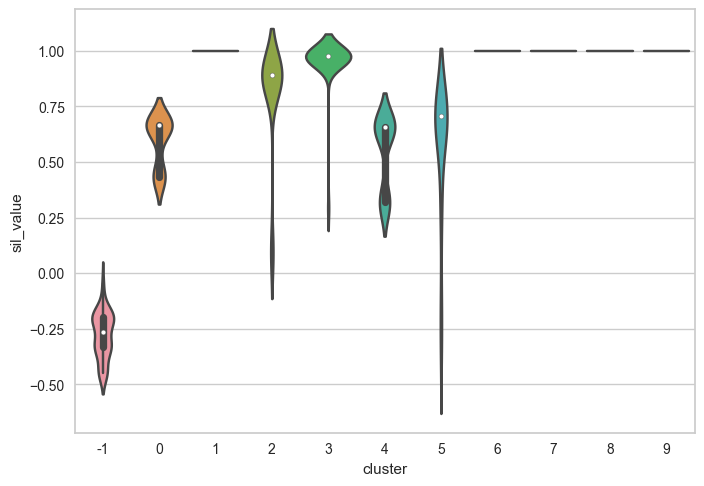

In [37]:
sns.violinplot(data=res_sil, x='cluster', y='sil_value', fill=True)

c:\Users\tomasito\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\tomasito\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='cluster', ylabel='sil_value'>

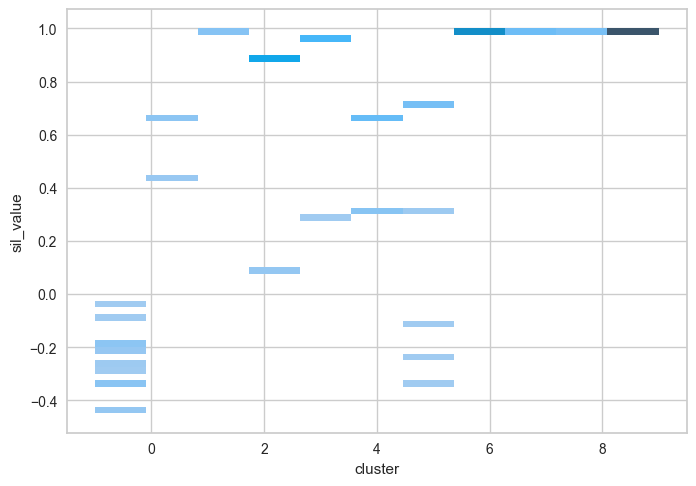

In [38]:
sns.histplot(data=res_sil, x='cluster', y='sil_value', fill=True)

In [40]:
res_sil.groupby('cluster').mean('sil_value')

,sil_value
cluster,
-1,-0.278012
0,0.593211
1,1.000000
2,0.806847
3,0.958363
4,0.545455
5,0.570122
6,1.000000
7,1.000000
